***
# Projet en traitement avancé du son: Implémentation d'une Talk-Box.

  + **Réalisé par:**
    + Karim HOCINE
    + Rabah Moulai
    + Anis NEHMAR
    + Chihabeddine LAKHMAMRA


***

# Bibliothèque

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
import matplotlib.pyplot as plt
from scipy.io import  wavfile as wav
from IPython.display import display, Audio
from scipy import convolve
import time

# Implémentation de fonctions utiles aux calculs:

In [29]:
# convolution discrete
def conv(x, h):
  y = np.copy(x)
  for t in range(x.shape[0]):
    som = 0
    for n in range(8, len(y[t])):
      for i in range(h.shape[1]):
        som += h[t,i] * x[t, n-i]
      
      y[t, n] = som

  return y

def conv2(x, h):
  y = np.copy(x)
  for t in range(x.shape[0]):
    y[t] = convolve(x[t], h[t], 'same')
  return y

# Fonction pour découper un signal en trame
def dec_trame(signal, Nwin, Nhop):
    N = len(signal)
    
    # Nombre de trames
    nb_trame = int((N - Nwin)//Nhop)
    
    # Découage  en trame de temps_trame
    signal_trame = np.zeros((nb_trame + 1, Nwin))
    for i in range(nb_trame + 1):
        signal_trame [i, :] = signal[i*Nhop: Nwin + i*Nhop]*np.hamming(Nwin)

    return  signal_trame

# Fonction pour reconstruire le signal à partir de ses trames
def reconstruct_signal(signal, Nwin, Nhop):
  x = np.zeros((signal.shape[0], signal.shape[0]*Nhop + Nwin))
  x_vect = np.zeros((signal.shape[0]*Nhop + Nwin))

  for k in range(signal.shape[0]):
    x[k,k*Nhop: k*Nhop + Nwin] = signal[k, :]

  for k in range(signal.shape[0]):
    x_vect += x[k,:] 
    K = np.sum(np.hamming(Nwin))/Nhop

  x_vect = x_vect/K
  return x_vect


  # Fonction de préaccentuation
def preaccentuation(signal):
  s = np.copy(signal)
  for i in range(1, len(signal)):
    s[i] = signal[i] - signal[i-1]
  return s

# Fonction de transfert du filtre
def H(z,trame):
  som = 0
  for i in range(1,len(trame)):
    som += trame[i]*z**(-i)
  H = 1/(1-som)
  return H

def Hf(f, T, trame):
  xf = H(np.exp(-2j*np.pi*f*T), trame)
  return xf

# Calcul de l'énergie de chaque trame
def calcul_energie(signal, coef):
  Q = np.zeros((coef.shape[0], 1))
  for t in range (len(signal)):
    somme = 0
    for j in range(8, len(signal[t])):
      som = signal[t,j]
      for k in range(8):
        som += coef[t,k] * signal[t,j-k]
      somme += som**2
    Q[t] = somme

  return np.sqrt(Q/len(signal))

In [30]:
Fe, signal = wav.read("a.wav")
display(Audio(signal, rate=Fe))

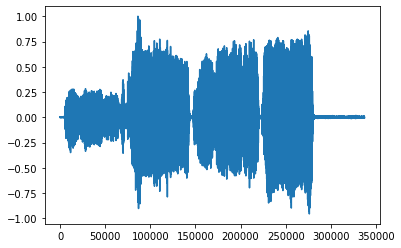

In [31]:
signal = signal / signal.max()
plt.plot(signal)

# Découpage du signal en trame

In [32]:
Te = 1/Fe
N = len(signal)
# Calcul du nombre d'echantillons par trame de 20 ms
n_trame = int(20*10**(-3) / Te)
nb_trame = int(N/n_trame)
Nwin = int(20*1e-3 / Te)
Nhop = int(Nwin//2)

print("Nwin =",Nwin)
print("Nhop =",Nhop)

Nwin = 882
Nhop = 441


In [33]:
# Préaccentuation pour améliorer le résultat de l'analyse LPC
signal =  preaccentuation(signal)
sf = dec_trame(signal, Nwin, Nhop)
print("vocal signal shape: ",sf.shape)

vocal signal shape:  (763, 882)


# Etape 1: Analyse LPC:

## 1 - Construire la Matrice $R_{pk}$

In [34]:
def mat_rpk(signal_trame, K=4):
  K = K
  Rpk = np.zeros((signal_trame.shape[0],2*K, 2*K))
  Rp = np.zeros((signal_trame.shape[0], 2*K))
  ak = np.zeros((signal_trame.shape[0], 2*K))

  for i in range(len(signal_trame)):
      for p in range(2*K):
          for k in range(2*K):
              for e in range(len(signal_trame[i])):
                  if (e-p) >= 0 and (e-k)>= 0:
                      Rpk[i,p,k] += signal_trame[i, e-p] *signal_trame[i, e-k]

  return Rpk           

In [35]:
Rpk = mat_rpk(sf)

## 2 - Construire la matrice $r$

In [36]:
def mat_rp(signal_trame):
  Rp = np.zeros(( signal_trame.shape[0], 8))
  for i in range(len(Rpk)):
      for p in range(8):
          for e in range(len(signal_trame[i])):
              if e-p >= 0:
                  Rp[i,p] += signal_trame[i, e-p] *signal_trame[i, e]
              else:
                  Rp[i,p] = 0
                   
  return Rp            

## 3 - Calcul des coefficients $a_k$ par résolution de système matriciel

In [37]:
Rp = mat_rp(sf)
ak0 = np.zeros((sf.shape[0], 8))
index = 1
for index in range(len(ak0)):
  ak0[index] = np.dot(np.linalg.inv(Rpk[index]),(-Rp[index]))


## 4 -  Résultats:

In [38]:
# Signal musical
Fe2, music = wav.read("piano.wav")
display(Audio(music, rate=Fe2))


# Calcul des paramètres du signal
Te = 1/Fe2
N = len(music)
# Calcul du nombre d'echantillons par trame de 20 ms
n_trame = int(20*10**(-3) / Te)
nb_trame = int(N/n_trame)
Nwin = int(20*1e-3 / Te)
Nhop = int(Nwin//2)

print("Nwin =",Nwin)
print("Nhop =",Nhop)

# Découpage du siangl musical en trame
music_trame = dec_trame(music, Nwin, Nhop)
print("music signal shape: ", music_trame.shape)


Nwin = 882
Nhop = 441
music signal shape:  (1132, 882)


In [39]:
# Récupérer le meme nombre de trame que le signal vocal et normaliser le signal musical
music_trame = music_trame[0:491]/music_trame.max()
music_trame.shape

(491, 882)

In [40]:
# Convolution
signal_filtre = conv2(music_trame, ak0)

# Reconstruction du signal
x_vect = reconstruct_signal(signal_filtre, Nwin, Nwin)
display(Audio(x_vect, rate=Fe))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.convolve is deprecated and will be removed in SciPy 2.0.0, use numpy.convolve instead


# Etape 2 : Algorithme Durbin-Levinson

## 1- Algorithme Durbin-Levinson

In [41]:
# initialisation des vecteurs
def durbin_levinson(signal_trame,Rpk, kk=4 ):
  K = kk
  ak = np.zeros((signal_trame.shape[0], 2*K))
  E = np.zeros((2*K))

  # Initialisation des a0 à 1 sur toutres les trames
  ak[:,0] = 1
  for t in range(len(Rpk)):
    E[0] = Rpk[t, 0, 0]
    for i in range(1, 2*K):
      sum = 0
      ki = Rpk[t,i,i]
      for j in range(i-1):
        sum += ak[t, i-1]*Rpk[t,  np.abs(i-j), np.abs(i-j)]
      sum = (1/E[i-1])* (Rpk[t, i, i] - sum)

      ak[t, i] = ki
      ak[t,0:i+1]
      for z in range(1, i+1):
        ak[t,z] = ak[t,z-1] - ki* ak[t, z - i]   

      E[i] = (1 - ki**2)* E[i-1]

  return ak

## 2 - Construction de la matrice Toeplitz

In [42]:
def mat_rpk_diag(signal_trame, K=4):
  # Ordre du filtre est 2*K
  K = K
  Rpk = np.zeros((signal_trame.shape[0],2*K, 2*K))
  Rp = np.zeros((signal_trame.shape[0], 2*K))
  ak = np.zeros((signal_trame.shape[0], 2*K))

  for i in range(len(signal_trame)):
      for p in range(2*K):
          for k in range(2*K):
              for e in range(len(signal_trame[i])):
                  if np.abs(k-p) <= e:
                      Rpk[i,p,k] += signal_trame[i, e] *signal_trame[i, e- np.abs(k-p)]

  return Rpk   

## 3 - Calcul des coéfficients $a_k$

In [43]:
Rpk_diag = mat_rpk_diag(sf)
ak = durbin_levinson(sf, Rpk_diag)

## 4 - Résultats

In [44]:
# Récupérer le meme nombre de trame que le signal vocal et normaliser le signal musical
music_trame = music_trame[0:491]/music_trame.max()
music_trame.shape

(491, 882)

In [58]:
# Convolution
signal_filtre2 = conv2(music_trame, 1000*ak)

# Reconstruction du signal
x_vect2 = reconstruct_signal(signal_filtre2, Nwin, Nhop)
display(Audio(x_vect2, rate=Fe2))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.convolve is deprecated and will be removed in SciPy 2.0.0, use numpy.convolve instead


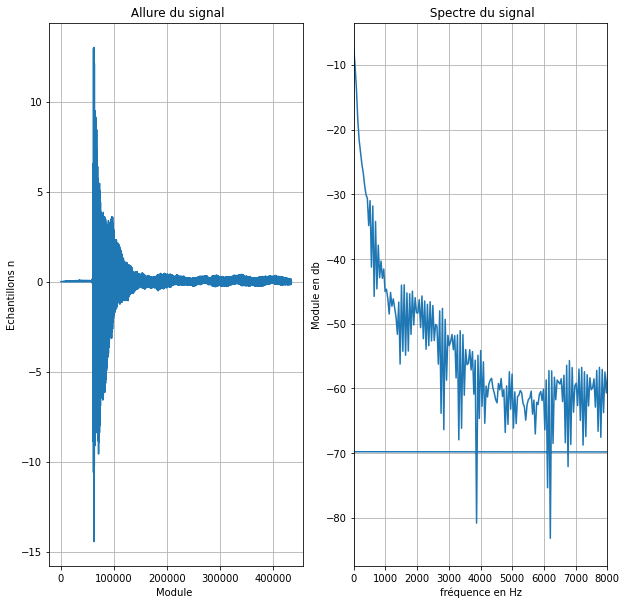

In [53]:
def plot(signal,Fe = 44100, nfft=1024):
  plt.figure(figsize=(10,10))
  # Allure temporelle
  plt.subplot(121)
  plt.plot(signal)
  plt.xlabel("Module ")
  plt.ylabel("Echantillons n")
  plt.title(" Allure du signal")
  plt.grid()

  # Spectre
  xf = np.fft.fft(signal, nfft)
  f = np.fft.fftfreq(nfft, 1/Fe)
  plt.subplot(122)
  plt.plot(f, 20*np.log10(np.abs(xf)))
  plt.xlabel("fréquence en Hz")
  plt.ylabel("Module en db")
  plt.title(" Spectre du signal")
  plt.xlim((0,8000))
  plt.grid()

plot(x_vect2)